시각화

5.2

holy1,2 => 그래프 2개


5.3

지역마다 장르 => 그래프 3개

6.1
주, 월 장르,  2개 golden week




요일 장르 이름 holy1,2 month, , golden week => 레스토랑 평소에 비해 얼마나 운영하는지  => 시계열 주기를 가지고 있고 => 

주//// 달마다 장르별 차이, golden week => (레스토랑 평소에 비해 얼마나 운영수 / 방문자들 평균(골든 vs 다른 평범한 1주)


hue => 각월마다 장르 = hue 방문수를 count


가게당 요일별 최대최소평균 => 가게당 특성부여 x
장르별 요일 최소최대평균 장르,가게 => 

/아이디당 요일별 최소최대 평균, 

날씨 강수량 => 오고 안오고 / 간격 =>

평균온도, 최대, 최소 =>


모델

lgm => gridsearch



////노쇼 시간/// 유동인구/// hpg => 지역 ///



month


In [1]:
import time
import numpy as np
import pandas as pd
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import *
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
import warnings 
warnings.filterwarnings('ignore')


/opt/conda/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
air_reserve = pd.read_csv('air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv('hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv('air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv('hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv('air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv('store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv('date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv('sample_submission.csv')

In [3]:
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek

In [4]:
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)

### 1. Visitors에 대한 관찰

### a. 날짜별 방문자수

<AxesSubplot:xlabel='visit_date'>

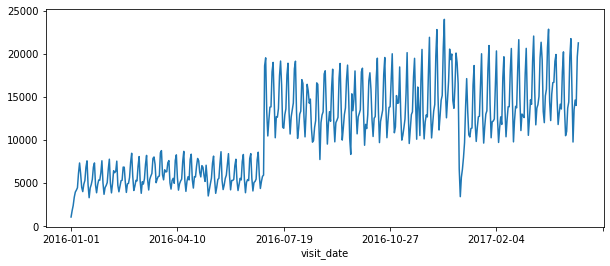

In [5]:
fig = plt.figure(figsize = (10, 4))
air_visit.groupby(['visit_date'])['visitors'].sum().plot()

- 주기적인 패턴이보인다 => 주, 월별로 분석해볼 생각을 할 수 있다.
- 16년 7월쯤 급격히 증가한다,

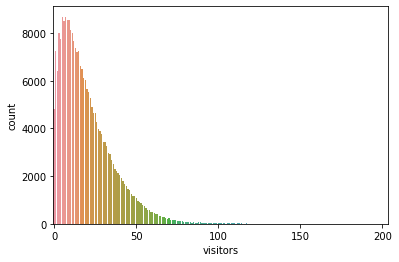

In [6]:
ax = sns.countplot('visitors', data = air_visit)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

- 각 날짜별 가게에 방문자 수들간에 심하게 치우쳐짐을 확인가능하다

Text(0, 0.5, 'median_visitor')

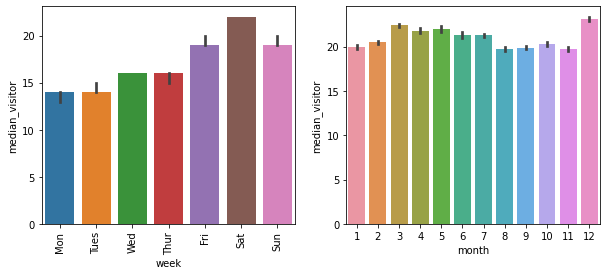

In [7]:
from numpy import median
f, ax = plt.subplots(1, 2, figsize = (10, 4))
air_visit['dow'] = pd.to_datetime(air_visit['visit_date']).dt.dayofweek
air_visit['month'] = pd.to_datetime(air_visit['visit_date']).dt.month
sns.barplot('dow','visitors',data = air_visit, estimator=median, ax = ax[0])
ax[0].set_xlabel('week')
ax[0].set_ylabel('median_visitor')
ax[0].set_xticklabels(['Mon','Tues',"Wed","Thur","Fri","Sat",'Sun'], rotation='vertical', fontsize=10)
sns.barplot('month','visitors',data = air_visit, ax = ax[1])
ax[1].set_ylabel('median_visitor')

Text(0, 0.5, 'mean_visitor')

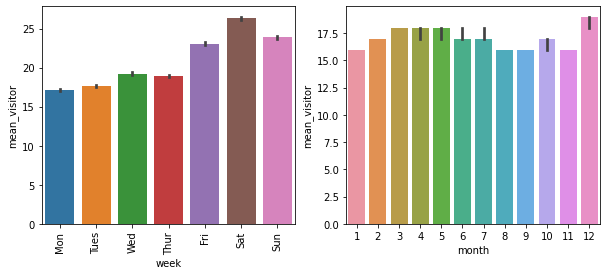

In [8]:
f, ax = plt.subplots(1, 2, figsize = (10, 4))
air_visit['dow'] = pd.to_datetime(air_visit['visit_date']).dt.dayofweek
air_visit['month'] = pd.to_datetime(air_visit['visit_date']).dt.month
sns.barplot('dow','visitors',data = air_visit, ax = ax[0])
ax[0].set_xlabel('week')
ax[0].set_ylabel('mean_visitor')
ax[0].set_xticklabels(['Mon','Tues',"Wed","Thur","Fri","Sat",'Sun'], rotation='vertical', fontsize=10)
sns.barplot('month','visitors',data = air_visit, estimator=median, ax = ax[1])
ax[1].set_ylabel('mean_visitor')

- mean이나 median이나 별반 다른게 없다
- 각 요일별로 방문자 수들의 특성이 보인다

In [9]:
air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])

In [10]:
lbl = LabelEncoder()
air_store['air_genre_name0'] = air_store['air_genre_name'].copy()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])
air_store['genre_count_per_area'] = air_store.groupby(['air_genre_name','air_area_name'])['store_id'].transform('count')
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

#골든 위크
date_info['golden_week'] = (((date_info['visit_date'].str[5:7] == '04') & (date_info['visit_date'].str[8:10].isin(['29','30']))) |\
                            ((date_info['visit_date'].str[5:7]== '05') & (date_info['visit_date'].str[8:10].isin(['01','02', '03', '04', '05'])))|
                           ((date_info['visit_date'].str[0:5]== '2017') & (date_info['visit_date'].str[5:7]== '05') & (date_info['visit_date'].str[8:10].isin(['06','07'])))).astype(int)
                                                                                                                                                              

data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2','golden_week']], on=['visit_date'],how='left')

## 장르와 요일, 월간의 관계

In [11]:
data['month'] = pd.to_datetime(data['visit_date']).dt.month

In [12]:
train_size = len(air_visit)
train = data[:train_size]
test = data[train_size:]

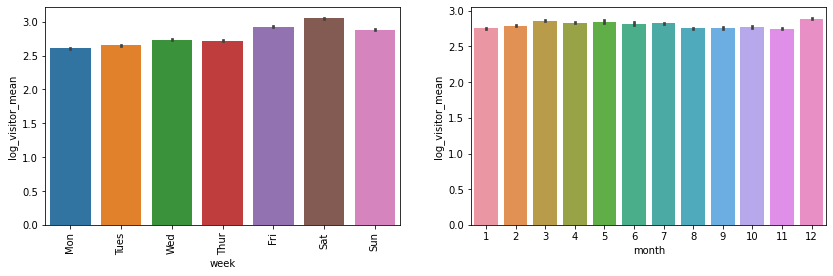

In [13]:
f, ax = plt.subplots(1, 2, figsize = (14, 4))
sns.barplot(x="dow", y="visitors", data=train, ax = ax[0])
ax[0].set_xticklabels(['Mon','Tues',"Wed","Thur","Fri","Sat",'Sun'], rotation='vertical', fontsize=10)
ax[0].set_xlabel('week')
ax[0].set_ylabel('log_visitor_mean')
sns.barplot(x="month", y="visitors", data=train, ax = ax[1])
ax[1].set_ylabel('log_visitor_mean')
plt.show()

In [14]:
train.columns

Index(['store_id', 'visit_date', 'visitors', 'id', 'dow', 'month',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'air_area_name0', 'air_genre_name0', 'genre_count_per_area',
       'holiday_flg', 'holiday_flg2', 'golden_week'],
      dtype='object')

In [15]:
train['air_genre_name'].unique()

array([ 4,  7,  2,  1,  6, 10, 11,  5,  8, 13,  9, 12,  3,  0])

In [16]:
train['air_genre_name0'].unique()

array(['Dining bar', 'Izakaya', 'Cafe/Sweets', 'Bar/Cocktail',
       'Italian/French', 'Okonomiyaki/Monja/Teppanyaki', 'Other',
       'International cuisine', 'Japanese food', 'Yakiniku/Korean food',
       'Karaoke/Party', 'Western food', 'Creative cuisine', 'Asian'],
      dtype=object)

In [17]:
genre_dict = {}
for index, genre_name in enumerate(train['air_genre_name0'].unique()):
    genre_dict[genre_name] = train['air_genre_name'].unique()[index]

In [18]:
df_genre_dow = train.groupby(['air_genre_name', 'dow'])['visitors'].mean().reset_index()
df_genre_month = train.groupby(['air_genre_name', 'month'])['visitors'].mean().reset_index()

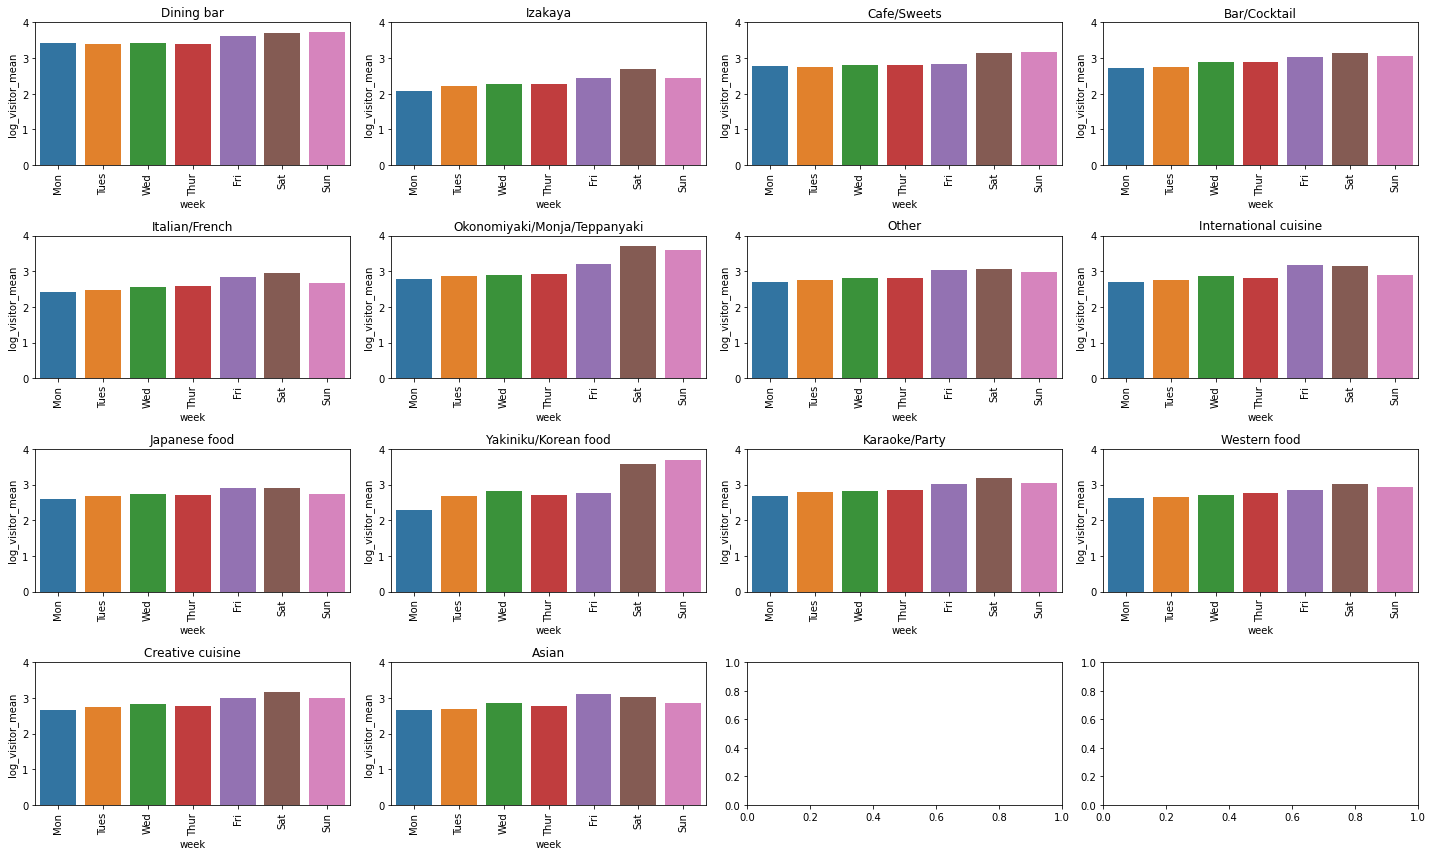

In [19]:
f, ax = plt.subplots(4, 4, figsize = (20, 12))
for i, key in enumerate(genre_dict.keys()):
    j = i % 4
    k = int(i / 4)
    sns.barplot(x="dow", y="visitors", data = df_genre_dow[df_genre_dow['air_genre_name'] == i], ax = ax[k][j])
    ax[k][j].set_title(key)
    ax[k][j].set_xticklabels(['Mon','Tues',"Wed","Thur","Fri","Sat",'Sun'], rotation='vertical', fontsize=10)
    ax[k][j].set_xlabel('week')
    ax[k][j].set_ylabel('log_visitor_mean')
    ax[k][j].set(ylim = (0, 4))
plt.tight_layout()
plt.show()

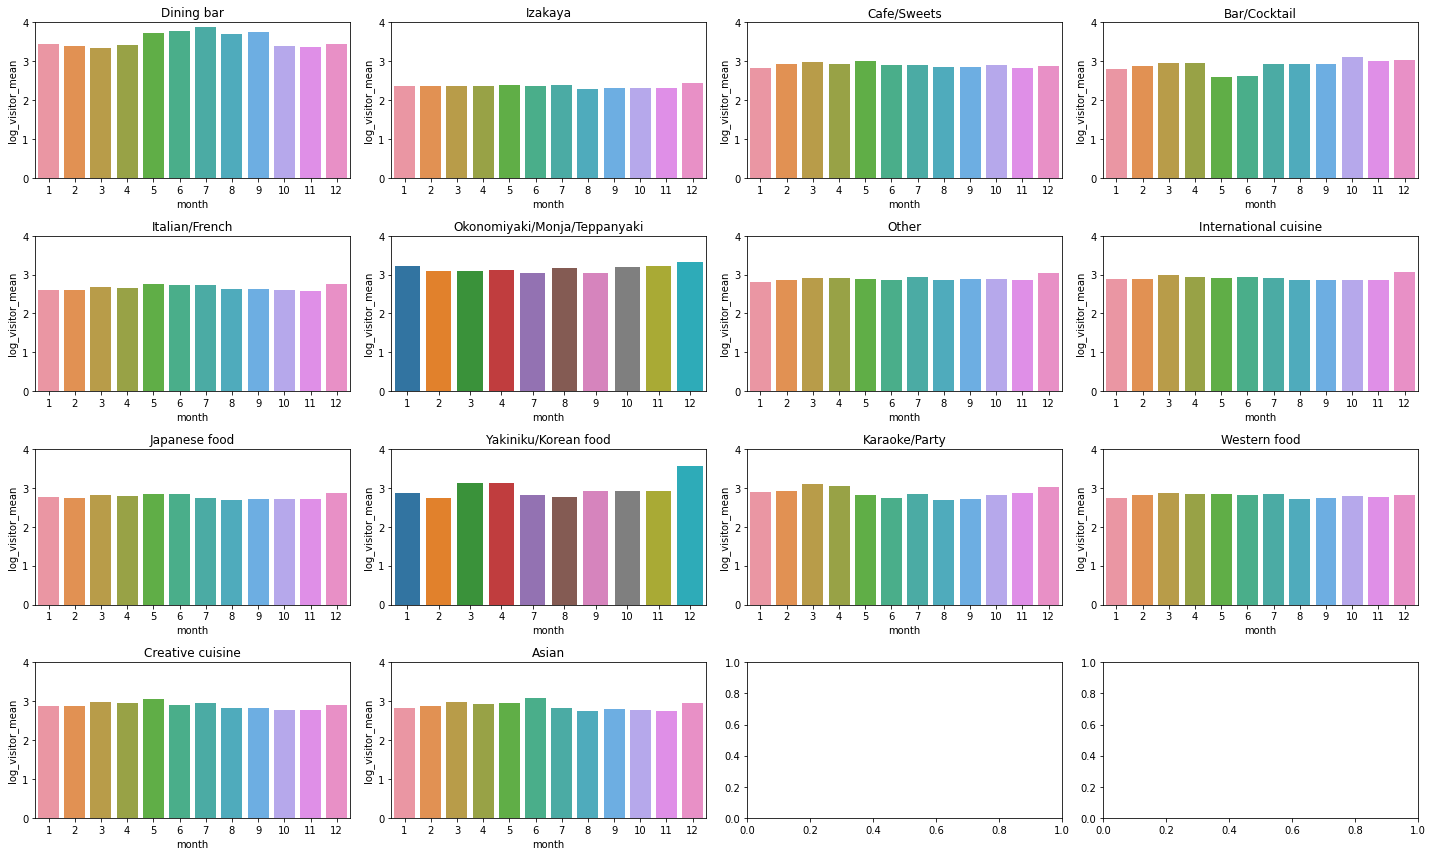

In [20]:
f, ax = plt.subplots(4, 4, figsize = (20, 12))
for i, key in enumerate(genre_dict.keys()):
    j = i % 4
    k = int(i / 4)
    sns.barplot(x="month", y="visitors", data = df_genre_month[df_genre_month['air_genre_name'] == i], ax = ax[k][j])
    ax[k][j].set_title(key)
    #ax[k][j].set_xticklabels(['Mon','Tues',"Wed","Thur","Fri","Sat",'Sun'], rotation='vertical', fontsize=10)
    ax[k][j].set_xlabel('month')
    ax[k][j].set_ylabel('log_visitor_mean')
    ax[k][j].set(ylim = (0, 4))
plt.tight_layout()
plt.show()

장르별 월마다 다른 패턴을 보이기도함

## Golden Week

In [29]:
train[train['golden_week'] == 1]['store_id'].nunique()

306

In [30]:
train[train['golden_week'] == 0]['store_id'].nunique()

829

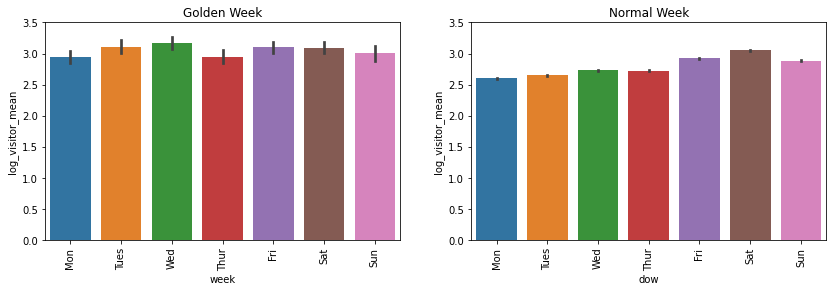

In [39]:
f, ax = plt.subplots(1, 2, figsize = (14, 4))
sns.barplot(x="dow", y="visitors", data=train[train['golden_week'] == 1], ax = ax[0])
ax[0].set_xticklabels(['Mon','Tues',"Wed","Thur","Fri","Sat",'Sun'], rotation='vertical', fontsize=10)
ax[0].set_xlabel('week')
ax[0].set_ylabel('log_visitor_mean')
ax[0].set_title('Golden Week')
ax[0].set(ylim = (0, 3.5))
sns.barplot(x="dow", y="visitors", data=train[train['golden_week'] == 0], ax = ax[1])
ax[1].set_xticklabels(['Mon','Tues',"Wed","Thur","Fri","Sat",'Sun'], rotation='vertical', fontsize=10)
ax[1].set_ylabel('log_visitor_mean')
ax[1].set_title('Normal Week')
ax[1].set(ylim = (0, 3.5))
plt.show()

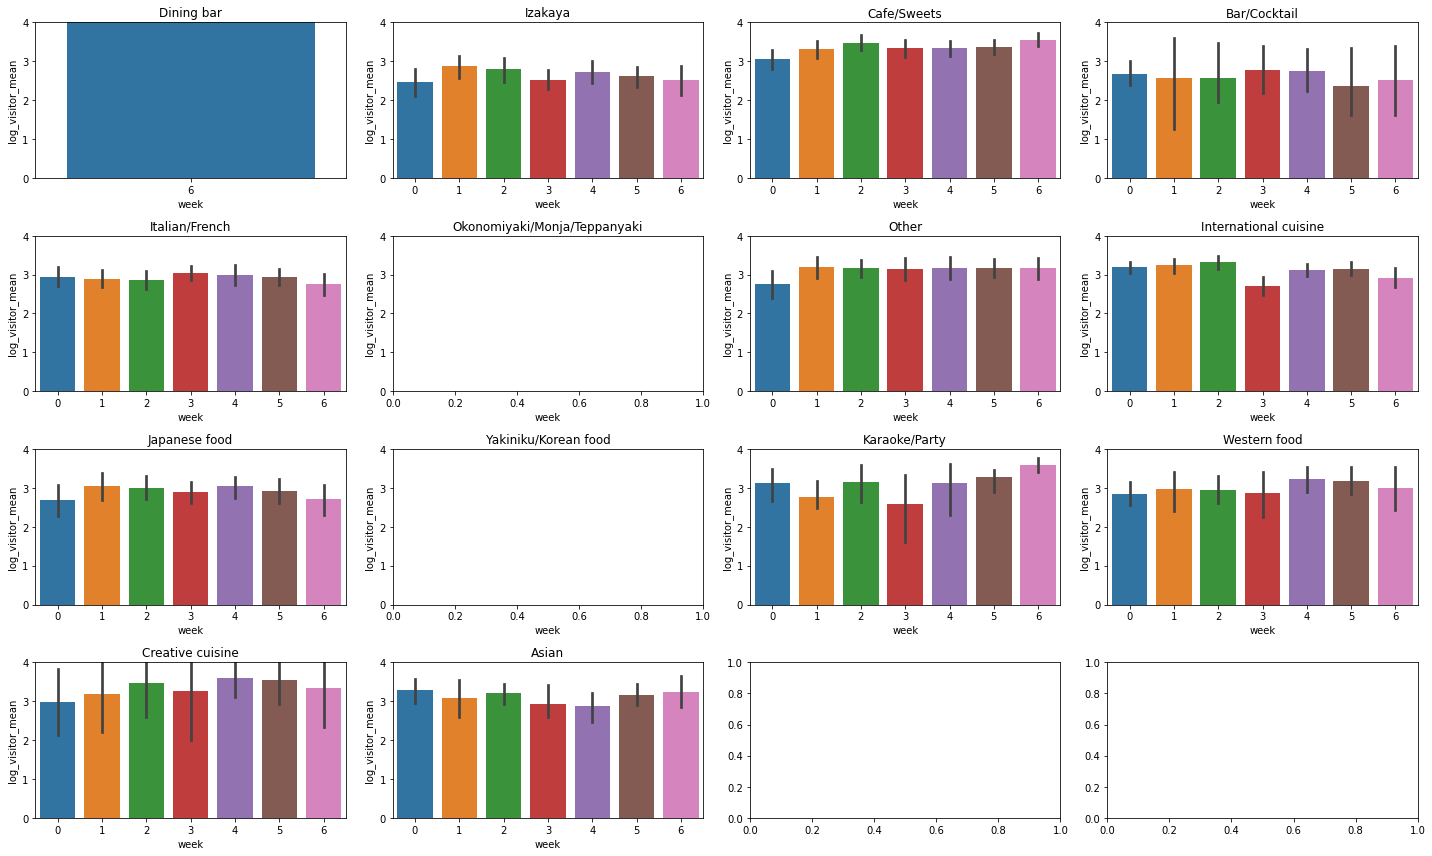

In [66]:
f, ax = plt.subplots(4, 4,  figsize = (20, 12))
for i, key in enumerate(genre_dict.keys()):
    k = int(i / 4)
    j = i % 4
    if not train[(train['golden_week'] == 1) & (train['air_genre_name'] == i)].empty:
        sns.barplot(x="dow", y="visitors", data = train[(train['golden_week'] == 1) & (train['air_genre_name'] == i)], ax = ax[k][j])
    ax[k][j].set_title(key)
    #ax[k][j].set_xticklabels(['Mon','Tues',"Wed","Thur","Fri","Sat",'Sun'], rotation='vertical', fontsize=10)
    ax[k][j].set_xlabel('week')
    ax[k][j].set_ylabel('log_visitor_mean')
    ax[k][j].set(ylim = (0, 4))

plt.tight_layout()
plt.show()

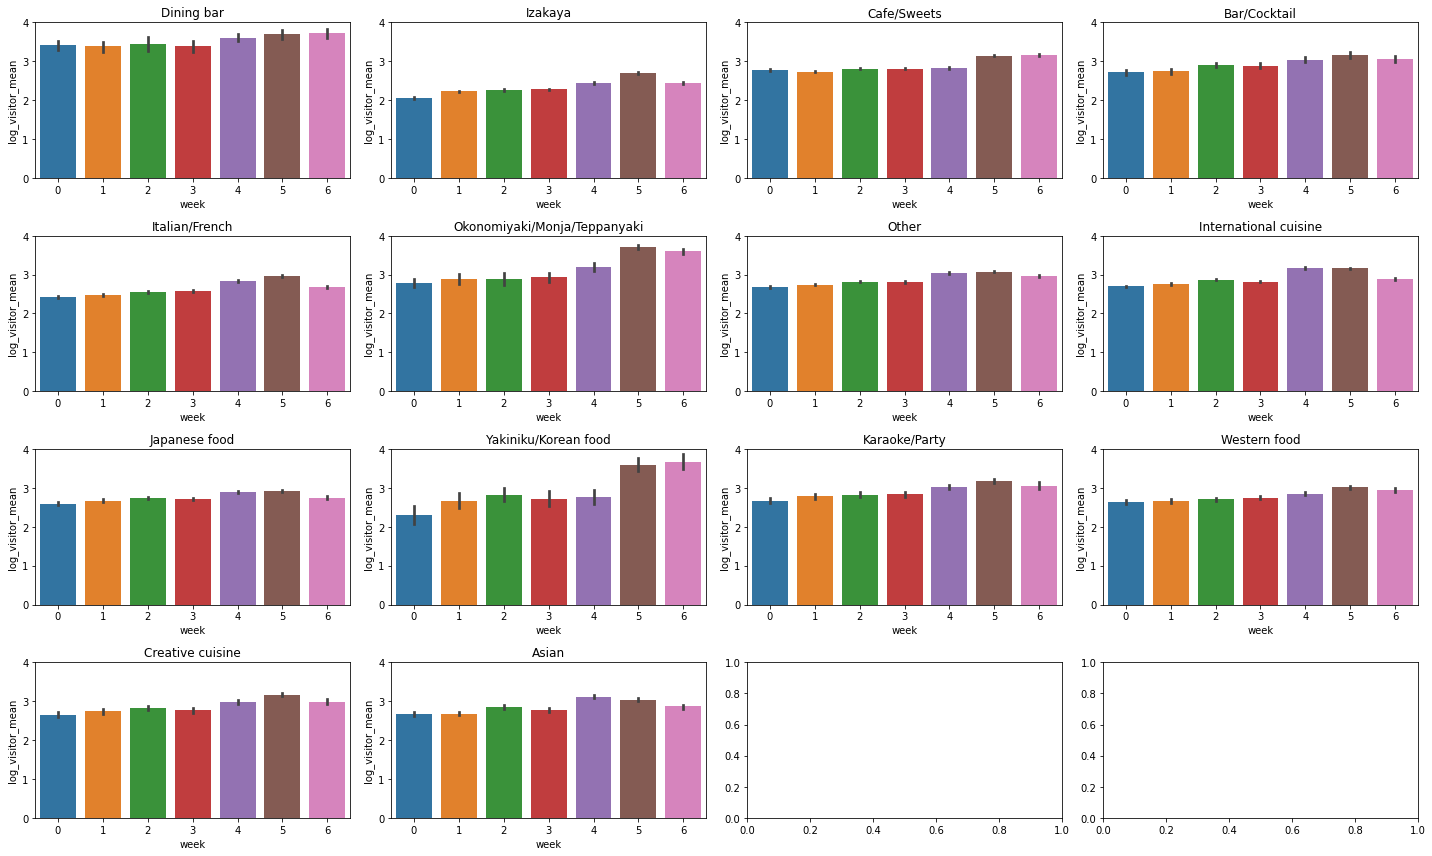

In [70]:
f, ax = plt.subplots(4, 4,  figsize = (20, 12))
for i, key in enumerate(genre_dict.keys()):
    k = int(i / 4)
    j = i % 4
    if not train[(train['golden_week'] == 0) & (train['air_genre_name'] == i)].empty:
        sns.barplot(x="dow", y="visitors", data = train[(train['golden_week'] == 0) & (train['air_genre_name'] == i)], ax = ax[k][j])
    ax[k][j].set_title(key)
    #ax[k][j].set_xticklabels(['Mon','Tues',"Wed","Thur","Fri","Sat",'Sun'], rotation='vertical', fontsize=10)
    ax[k][j].set_xlabel('week')
    ax[k][j].set_ylabel('log_visitor_mean')
    ax[k][j].set(ylim = (0, 4))

plt.tight_layout()
plt.show()

In [37]:
train[(train['golden_week'] == 1) & (train['holiday_flg'] == 1)]['dow'].unique()

array([4, 1, 2, 3])

- 화수목금이 골든 위크이자 공휴일이였음
- 월요일도 그에따라 영향받음을 알 수 읶음

많은 곳이 문을 닫는다

In [ ]:
train[train['golden_week'] == 1][]

In [ ]:
train[data['golden_week'] == 1].groupby(['store_id'])['vis']

In [21]:
import math 

In [22]:
data['air_store_id2'] = lbl.fit_transform(data['store_id'])

In [23]:
data['id_dow_visitor_max']= data.groupby(['store_id', 'dow'])['visitors'].transform(max)
data['id_dow_visitor_min']= data.groupby(['store_id', 'dow'])['visitors'].transform(min)
data['id_dow_visitor_mean']= data.groupby(['store_id', 'dow'])['visitors'].transform(np.mean)

In [24]:
data['genre_dow_visitor_min']= data.groupby(['air_genre_name', 'dow'])['visitors'].transform(min)
data['genre_dow_visitor_max']= data.groupby(['air_genre_name', 'dow'])['visitors'].transform(max)
data['genre_dow_visitor_mean']= data.groupby(['air_genre_name', 'dow'])['visitors'].transform(np.mean)

## 모델 구성 및 결과 예측

In [48]:
train_size = len(air_visit)
train = data[:train_size]
test = data[train_size:]

In [49]:
train.columns

Index(['store_id', 'visit_date', 'visitors', 'id', 'dow', 'month',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'air_area_name0', 'air_genre_name0', 'genre_count_per_area',
       'holiday_flg', 'holiday_flg2', 'golden_week', 'air_store_id2',
       'id_dow_visitor_max', 'id_dow_visitor_min', 'id_dow_visitor_mean',
       'genre_dow_visitor_min', 'genre_dow_visitor_max',
       'genre_dow_visitor_mean'],
      dtype='object')

In [ ]:
golden_week

In [73]:
col = ['dow', 'air_genre_name', 'air_area_name0', 'holiday_flg', 'holiday_flg2', 'month','golden_week',
      'genre_dow_visitor_min', 'genre_dow_visitor_max','genre_dow_visitor_mean','id_dow_visitor_max','id_dow_visitor_min',
      'id_dow_visitor_mean','genre_count_per_area','air_store_id2']
col

['dow',
 'air_genre_name',
 'air_area_name0',
 'holiday_flg',
 'holiday_flg2',
 'month',
 'golden_week',
 'genre_dow_visitor_min',
 'genre_dow_visitor_max',
 'genre_dow_visitor_mean',
 'id_dow_visitor_max',
 'id_dow_visitor_min',
 'id_dow_visitor_mean',
 'genre_count_per_area',
 'air_store_id2']

In [67]:
#col = ['dow', 'air_genre_name', 'air_area_name0','genre_count_per_area', 'holiday_flg', 'holiday_flg2', 'month', 'golden_week',
#      'id_dow_visitor_max','id_dow_visitor_min', 'id_dow_visitor_mean','air_store_id2']

In [68]:
import lightgbm as lgb

In [74]:
params = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}

In [75]:
lgb_train = lgb.Dataset(train[col], train['visitors'])
lgb_test = lgb.Dataset(test[col], test['visitors'])

gbm = lgb.train(params,lgb_train,2300)
pred = gbm.predict(test[col])

In [76]:
test['visitors'] = np.expm1(pred)

In [77]:
sub = test[['id','visitors']].copy()
sub.to_csv('submission.csv', index=False)

## 이상치 Reservation

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [28]:
air_reserve.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,dow
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01,4
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,2016-01-01,4
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,2016-01-01,4
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,2016-01-01,4
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,2016-01-01,4


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


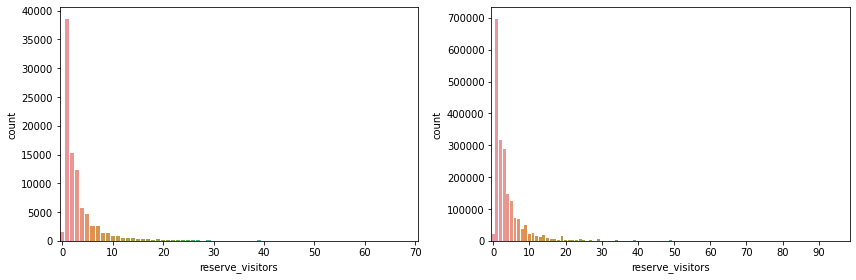

In [29]:
f, ax = plt.subplots(1, 2, figsize= (12, 4))
sns.countplot('reserve_visitors', data = air_reserve, ax = ax[0])
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(10))
ax[0].xaxis.set_major_formatter(ticker.ScalarFormatter())
sns.countplot('reserve_visitors', data = hpg_reserve, ax = ax[1])
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(10))
ax[1].xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tight_layout()
plt.show()

예약수의 차이 => 식당수도 다름..

In [25]:
air_reserve = air_reserve.rename(columns= {'reserve_visitors' : 'air_reserve_visitors'})
hpg_reserve = hpg_reserve.rename(columns= {'reserve_visitors' : 'hpg_reserve_visitors'})

In [26]:
air_store.head()

,store_id,air_genre_name,air_area_name,latitude,longitude,air_area_name0,genre_count_per_area,air_genre_name0
0,air_0f0cdeee6c9bf3d7,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,Italian French
1,air_7cc17a324ae5c7dc,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,Italian French
2,air_fee8dcf4d619598e,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,Italian French
3,air_a17f0778617c76e2,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,Italian French
4,air_83db5aff8f50478e,6,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,13,Italian French


In [42]:
hpg_air_reserve['store_id'].nunique()

314

In [43]:
air_visit['store_id'].nunique()

829

In [41]:
hpg_air_reserve = pd.merge(air_reserve, hpg_reserve[['store_id','visit_date','hpg_reserve_visitors']], on = ["store_id", "visit_date"], how = "left").fillna(0)
hpg_air_reserve = pd.merge(air_visit[['store_id','visit_date','visitors']], hpg_air_reserve, on = ["store_id", "visit_date"], how = "left").fillna(0)
#hpg_air_reserve = pd.merge(hpg_air_reserve, air_store[['store_id','air_genre_name','air_genre_name0','air_area_name','air_area_name0']], on = ["store_id"], how = "left")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


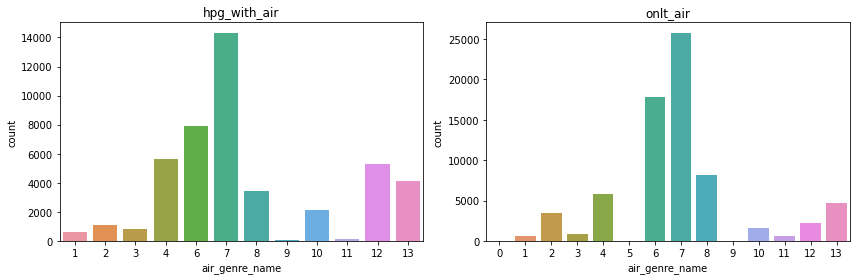

In [35]:
f, ax = plt.subplots(1, 2, figsize= (12, 4))
sns.countplot('air_genre_name', data = hpg_air_reserve[hpg_air_reserve['hpg_reserve_visitors'] != 0], ax = ax[0])
ax[0].set_title("hpg_with_air")
sns.countplot('air_genre_name', data = hpg_air_reserve[hpg_air_reserve['hpg_reserve_visitors'] == 0], ax = ax[1])
ax[1].set_title("onlt_air")
plt.tight_layout()
plt.show()

In [37]:
hpg_air_reserve[(hpg_air_reserve['air_genre_name'] == 0) | (hpg_air_reserve['air_genre_name'] == 5)]

,store_id,visit_datetime,reserve_datetime,air_reserve_visitors,visit_date,reserve_date,dow,hpg_reserve_visitors,visitors,air_genre_name,air_genre_name0,air_area_name,air_area_name0
83020,air_6b65745d432fd77f,2017-02-21 19:00:00,2017-02-21 14:00:00,7,2017-02-21,2017-02-21,1,0.0,19.0,5,International cuisine,Tōkyō-to Shibuya-ku Shibuya,7
85431,air_6b65745d432fd77f,2017-02-25 18:00:00,2017-02-23 12:00:00,3,2017-02-25,2017-02-23,5,0.0,48.0,5,International cuisine,Tōkyō-to Shibuya-ku Shibuya,7
90210,air_10bbe8acd943d8f6,2017-03-06 20:00:00,2017-01-15 00:00:00,40,2017-03-06,2017-01-15,0,0.0,12.0,0,Asian,Tōkyō-to Shibuya-ku Shibuya,7
90239,air_10bbe8acd943d8f6,2017-03-06 21:00:00,2017-01-18 17:00:00,12,2017-03-06,2017-01-18,0,0.0,12.0,0,Asian,Tōkyō-to Shibuya-ku Shibuya,7
103051,air_6b65745d432fd77f,2017-03-29 20:00:00,2017-03-29 14:00:00,4,2017-03-29,2017-03-29,2,0.0,17.0,5,International cuisine,Tōkyō-to Shibuya-ku Shibuya,7


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='air_genre_name', ylabel='count'>

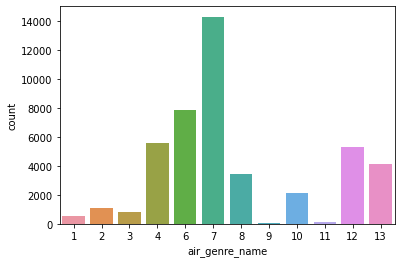

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='air_genre_name', ylabel='count'>

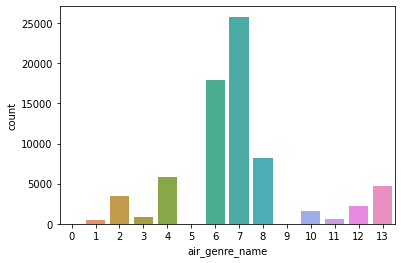

In [32]:
sns.countplot('air_genre_name', data = hpg_air_reserve[hpg_air_reserve['hpg_reserve_visitors'] == 0])

In [101]:
hpg_air_reserve

,store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,dow,hpg_reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01,4,0.0
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,2016-01-01,4,0.0
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,2016-01-01,4,0.0
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,2016-01-01,4,0.0
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,2016-01-01,4,4.0
...,...,...,...,...,...,...,...,...
117082,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6,2017-05-29,2017-04-17,0,0.0
117083,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8,2017-05-30,2017-04-19,1,0.0
117084,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3,2017-05-31,2017-04-12,2,0.0
117085,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10,2017-05-31,2017-04-19,2,0.0


In [77]:
air_reserve['reserve_visitors'].describe()

count    92378.000000
mean         4.481749
std          4.919669
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        100.000000
Name: reserve_visitors, dtype: float64

In [81]:
air_reserve['reserve_visitors'].mode()

0    2
dtype: int64

In [ ]:
air_reserve
hpg_reserve

In [35]:
def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

In [37]:
air_reserve

,store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,dow
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01,4
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,2016-01-01,4
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,2016-01-01,4
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,2016-01-01,4
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,2016-01-01,4
...,...,...,...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6,2017-05-29,2017-04-17,0
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8,2017-05-30,2017-04-19,1
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3,2017-05-31,2017-04-12,2
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10,2017-05-31,2017-04-19,2


In [43]:
from datetime import datetime

air_reserve['differ']  = pd.to_datetime(air_reserve['visit_date']) - pd.to_datetime(air_reserve['reserve_date'])

In [50]:
air_reserve['differ'] = air_reserve['differ'].astype(str)
air_reserve['differ'] = air_reserve['differ'].apply(lambda x : x.split(" ")[0])

In [61]:
air_reserve['differ'] = air_reserve['differ'].astype(int)

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


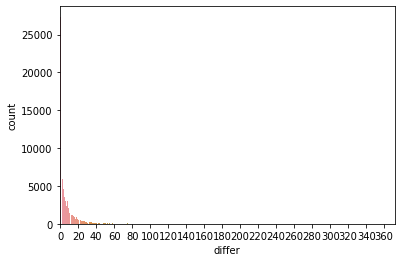

In [60]:
ax = sns.countplot(air_reserve['differ'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

In [64]:
famous_res_id = air_reserve[air_reserve['differ'] > 300]['store_id'].unique()

In [97]:
famous_res_id

array(['air_a17f0778617c76e2', 'air_f068442ebb6c246c',
       'air_2a485b92210c98b5', 'air_6b9fa44a9cf504a1',
       'air_e7fbee4e3cfe65c5', 'air_f911308e19d64236'], dtype=object)

In [89]:
air_reserve[(air_reserve['differ'] > 300) & (air_reserve['store_id'] == 'air_a17f0778617c76e2')]

,store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,dow,differ
21547,air_a17f0778617c76e2,2016-11-11 18:00:00,2016-01-05 17:00:00,16,2016-11-11,2016-01-05,4,311
21570,air_a17f0778617c76e2,2016-11-11 18:00:00,2016-01-08 21:00:00,9,2016-11-11,2016-01-08,4,308
21589,air_a17f0778617c76e2,2016-11-11 18:00:00,2016-01-07 21:00:00,7,2016-11-11,2016-01-07,4,309
21743,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-06 13:00:00,5,2016-11-11,2016-01-06,4,310
21744,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-12 00:00:00,4,2016-11-11,2016-01-12,4,304
21746,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-13 15:00:00,4,2016-11-11,2016-01-13,4,303
21747,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-07 17:00:00,6,2016-11-11,2016-01-07,4,309
21748,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-09 01:00:00,4,2016-11-11,2016-01-09,4,307
21750,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-04 21:00:00,72,2016-11-11,2016-01-04,4,312
21752,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-10 14:00:00,2,2016-11-11,2016-01-10,4,306


In [93]:
data[(data['store_id'] == 'air_a17f0778617c76e2') & (data['visit_date'] == '2016-11-11')]

,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,genre_count_per_area,holiday_flg,holiday_flg2,golden_week,month


In [ ]:
data[(data['store_id'] == 'air_a17f0778617c76e2') & (data['visit_date'] == '2016-11-11')]

<AxesSubplot:xlabel='visit_date'>

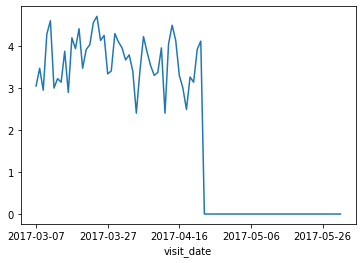

In [94]:
data[data['store_id'] == 'air_a17f0778617c76e2'].groupby(['visit_date'])['visitors'].sum().plot()

In [72]:
air_visit[air_visit['store_id'].isin(famous_res_id)].groupby('store_id')['visitors'].sum()

store_id
air_2a485b92210c98b5     2402
air_6b9fa44a9cf504a1     2513
air_a17f0778617c76e2     2096
air_e7fbee4e3cfe65c5    10220
air_f068442ebb6c246c     3735
air_f911308e19d64236    14816
Name: visitors, dtype: int64

In [83]:
air_visit.groupby('store_id')['visitors'].sum().sort_values().describe()

count      829.000000
mean      6378.351025
std       3919.690328
min        190.000000
25%       3328.000000
50%       5474.000000
75%       8791.000000
max      18717.000000
Name: visitors, dtype: float64

In [85]:
data[data['store_id'] == "air_a17f0778617c76e2"]

,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,genre_count_per_area,holiday_flg,holiday_flg2,golden_week,month
108729,air_a17f0778617c76e2,2017-03-07,3.044522,air_a17f0778617c76e2_2017-03-07,1,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,3
108730,air_a17f0778617c76e2,2017-03-08,3.465736,air_a17f0778617c76e2_2017-03-08,2,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,3
108731,air_a17f0778617c76e2,2017-03-09,2.944439,air_a17f0778617c76e2_2017-03-09,3,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,3
108732,air_a17f0778617c76e2,2017-03-10,4.276666,air_a17f0778617c76e2_2017-03-10,4,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,3
108733,air_a17f0778617c76e2,2017-03-11,4.595120,air_a17f0778617c76e2_2017-03-11,5,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272578,air_a17f0778617c76e2,2017-05-27,0.000000,air_a17f0778617c76e2_2017-05-27,5,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,1,0,5
272579,air_a17f0778617c76e2,2017-05-28,0.000000,air_a17f0778617c76e2_2017-05-28,6,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,1,0,5
272580,air_a17f0778617c76e2,2017-05-29,0.000000,air_a17f0778617c76e2_2017-05-29,0,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,5
272581,air_a17f0778617c76e2,2017-05-30,0.000000,air_a17f0778617c76e2_2017-05-30,1,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,5


In [69]:
air_reserve[air_reserve['store_id'].isin(famous_res_id)]

,store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,dow,differ
57,air_f911308e19d64236,2016-01-04 18:00:00,2016-01-04 15:00:00,2,2016-01-04,2016-01-04,0,0
99,air_f911308e19d64236,2016-01-06 12:00:00,2016-01-06 11:00:00,2,2016-01-06,2016-01-06,2,0
100,air_f911308e19d64236,2016-01-06 13:00:00,2016-01-04 11:00:00,2,2016-01-06,2016-01-04,2,2
135,air_f911308e19d64236,2016-01-06 20:00:00,2016-01-06 17:00:00,2,2016-01-06,2016-01-06,2,0
140,air_6b9fa44a9cf504a1,2016-01-06 23:00:00,2016-01-06 23:00:00,2,2016-01-06,2016-01-06,2,0
...,...,...,...,...,...,...,...,...
92299,air_f911308e19d64236,2017-05-20 11:00:00,2017-01-04 17:00:00,29,2017-05-20,2017-01-04,5,136
92317,air_2a485b92210c98b5,2017-05-21 00:00:00,2017-04-18 21:00:00,7,2017-05-21,2017-04-18,6,33
92322,air_2a485b92210c98b5,2017-05-21 19:00:00,2017-04-13 19:00:00,28,2017-05-21,2017-04-13,6,38
92334,air_6b9fa44a9cf504a1,2017-05-24 19:00:00,2017-04-06 18:00:00,4,2017-05-24,2017-04-06,2,48
